<img align="center" src="figures/course.png" width="800">

#                                    16720 (B) Bag of Visual Words - Assignment 2

     Instructor: Kris Kitani                       TAs:Paritosh (Lead), Rawal, Yan, Zen, Wen-Hsuan, Qichen

In [2]:
import nbimporter
import numpy as np
import scipy.ndimage
from skimage import io
import skimage.transform
import os,time
import util
import multiprocessing
import threading
import queue
import torch
import torchvision
import torchvision.transforms

## For Autograding P4, ensure uploading `trained_conf_matrix.npy` and `trained_system_deep.npz`.

### Deep Learning Features - An Alternative to ``Bag of Words``

As we have discussed in class, another powerful method for scene classification in computer vision is the employment of convolutional neural networks (CNNs) - sometimes referred to generically as $deep learning$. It is important to understand how previously trained (pretrained) networks can be used as another form of feature extraction, and how they relate to classical Bag of Words (BoW) features. We will be covering details on how one chooses the network architecture and training procedures later in the course. For this question, however, we will be asking you to deal with the VGG-16 pretrained network. VGG-16 is a pretrained Convolutional Neural Network (CNN) that has been trained on approximately 1.2 million images from the ImageNet Dataset (``http://image-net.org/index``) by the Visual Geometry Group (VGG) at University of Oxford. The model can classify images into a 1000 object categories (e.g. keyboard, mouse, coffee mug, pencil).

One lesson we want you to take away from this exercise is to understand the effectiveness of $deep$ $features$ for general classification tasks within computer vision - even when those features have been previously trained on a different dataset (i.e. ImageNet) and task (i.e. object recognition). 

#### Extracting Deep Features

To complete this question, you need to install the ``torchvision`` library from Pytorch, a popular Python-based deep learning library.
If you are using the Anaconda package manager (``https://www.anaconda.com/download/``), this can be done with the following command:
```
            conda install pytorch torchvision -c pytorch
```
To check that you have installed it correctly, make sure that you can ``import torch`` in a Python interpreter without errors.
Please refer to ``https://pytorch.org/`` for more detailed installation instructions. 

#### Q4.1.1 (25 Points)

We want to extract out deep features corresponding to the convolutional layers of theVGG-16 network.  In this problem, we will use the trained weights from the VGG network directly, but implement our own operations. To load the network, use the line
```
        vgg16 = torchvision.models.vgg16(pretrained=True).double()
```
followed by ``vgg16.eval()``
The latter line ensures that the VGG-16 network is in evaluation mode, not training mode.

path_img = "./data/aquarium/sun_aztvjgubyrgvirup.jpg"

image = io.imread(path_img)

image = image.astype('float')/255

vgg16 = torchvision.models.vgg16(pretrained=True).double()

vgg16.eval()

We want you to complete a function that is able to output $VGG-16$ network outputs at the **fc7** layer in
```
    def extract_deep_feature(x,vgg16_weights):
```
where ``x`` refers to the input image and ``vgg16_weights`` is a structure containing the CNN's network parameters. In this function you will need to write sub-functions ``multichannel_conv2d``, ``relu``, ``max_pool2d``, and ``linear`` corresponding to the fundamental elements of the CNN: multi-channel convolution, rectified linear units (ReLU), max pooling, and fully-connected weighting.

We have provided a helper function ``util.get_VGG16_weights()`` that extracts the weight parameters of VGG-16 and its meta information. The returned variable is a numpy array of shape $L\times 3$, where $L$ is the number of layers in VGG-16. The first column of each row is a string indicating the layer type. The second/third columns may contain the learned weights and biases, or other meta-information (\eg kernel size of max-pooling). Please refer to the function docstring for details.

In order to build the ``extract_deep_feature`` function, you should run a for-loop through each layer index until layer **fc7**, which corresponds to **the second linear layer** (Refer to VGG structure to see where **fc7** is). **Remember**: the output of the preceding layer should be passed through as an input to the next.

Details on the sub-functions needed for the ``extract_deep_feature`` function can be found below.

Please use ``scipy.ndimage.convolve`` and ``numpy`` functions to implement these functions instead of using pytorch. Please keep speed in mind when implementing your function, for example, using double for loop over pixels is not a good idea.

``multichannel_conv2d(x,weight,bias)``:

a function that will perform multi-channel 2D convolution which can be defined as follows, 

\begin{equation}
\mathbf{y}^{(j)} = \sum_{k=1}^{K} \begin{bmatrix} \mathbf{x}^{(k)} * \mathbf{h}^{(j,k)} \end{bmatrix} + \mathbf{b}[j] 
\end{equation}

where $*$ denotes $2D$ convolution, $\mathbf{x} = \{ \mathbf{x}^{(k)} \}_{k=1}^{K}$ is our vectorized $K$-channel input signal, $\mathbf{h} = \{ \mathbf{h}^{(j,k)} \}_{k=1,j=1}^{K,J}$ is our $J \times K$ set of vectorized convolutional filters and $\mathbf{r} = \{ \mathbf{y}^{(j)} \}_{j=1}^{J}$ is our $J$ channel vectorized output response. Further, unlike traditional single-channel convolution CNNs often append a bias vector $\mathbf{b}$ whose $J$ elements are added to the $J$ channels of the output response. 

To implement ``multichannel_conv2d``, you can use the Scipy convolution function directly with for loops to cycle through the filters and channels (``scipy.ndimage.convolve()``). All the necessary details concerning the number of filters ($J$), number of channels ($K$), filter weights ($\mathbf{h}$) and biases ($\mathbf{b}$) can be inferred from the shapes/dimensions of the weights and biases. Notice that pytorch's convolution function actually does correlation, so to get similar answer as pytroch with scipy, you need to flip the kernel on both axes using ``np.flip()``.

In [15]:
def multichannel_conv2d(x,weight,bias):
    '''
    Performs multi-channel 2D convolution.

    [input]
    * x: numpy.ndarray of shape (H,W,input_dim)
    * weight: numpy.ndarray of shape (output_dim,input_dim,kernel_size,kernel_size)
    * bias: numpy.ndarray of shape (output_dim)

    [output]
    * feat: numpy.ndarray of shape (H,W,output_dim)
    '''
    h, w, input_dims = x.shape
    output_dims = weight.shape[0]
    final_res = np.zeros((h, w, output_dims))
    '''
    HINTS:
    1.> for 2D convolution we need to use np.fliplr and np.flipud
    2.> can use scipy.ndimage.convolve with the flipped kernel
    3.> don't forget to add the bias
    '''
    # YOUR CODE HERE
    inter = np.zeros((h, w, input_dims))
    # filter = np.zeros((weight.shape[2], weight.shape[3]))
    for i in range(output_dims):
        for j in range(input_dims):
            filter = np.fliplr(np.flipud(weight[i,j,:,:]))
            inter[:,:,j] = scipy.ndimage.convolve(x[:,:,j], filter, mode = "constant")
        final_res[:,:,i] = np.sum(inter, axis = 2) + bias[i]    
    # raise NotImplementedError()
    return final_res

In [16]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import scipy.ndimage

def pytorch_conv2d(x, w, b):

    x_reorder = np.moveaxis(x, [0, 1, 2], [1, 2, 0])
    x_input = np.expand_dims(x_reorder, axis = 0)

    x_t = torch.from_numpy(x_input)
    w_t = torch.from_numpy(w)

    # print(f"{x_t.shape=}, {w_t.shape=}")

    o_t = F.conv2d(x_t, w_t, padding=1)

    output = o_t.numpy()
    
    output = output[0,:,:,:]

    return output

np.random.seed(0)
x = np.random.rand(10, 10, 2)
w = np.random.rand(4, 2, 3, 3)
b = np.zeros((4))

pyoutput = pytorch_conv2d(x, w, b)
cuoutput = multichannel_conv2d(x,w,b)

cuoutput = np.moveaxis(cuoutput, [0, 1, 2], [1, 2, 0])

diff = pyoutput - cuoutput

print(np.sum(diff))

1.9984014443252818e-14


```relu(x)```:

a function that shall perform the Rectified Linear Unit (ReLU) which can be defined mathematically as,

\begin{equation}
\mbox{ReLU}(x) = \max_{x}(x, 0)
\end{equation}

and is applied independently to each element of the matrix/vector $x$ passed to it.

In [3]:
def relu(x):
    '''
    Rectified linear unit.

    [input]
    * x: numpy.ndarray

    [output]
    * y: numpy.ndarray
    '''
    # YOUR CODE HERE
    y = np.maximum(x, 0)
    # raise NotImplementedError()
    return y


``max_pool2d(x,size):``

a function that shall perform max pooling over $x$ using a receptive field of size $size$ $\times$ $size$ (we assume a square receptive field here for simplicity).

  If the function receives a multi-channel input, then it should apply the max pooling operation across each input channel independently.
  
(Hint: making use of smart array indexing can drastically speed up the code.)

In [4]:
def max_pool2d(x,size):
    '''
    2D max pooling operation.

    [input]
    * x: numpy.ndarray of shape (H,W,input_dim)
    * size: pooling receptive field

    [output]
    * y: numpy.ndarray of shape (H/size,W/size,input_dim)
    '''
    h, w, dims = x.shape
    ind1 = np.floor(h/size).astype(int)
    ind2 = np.floor(w/size).astype(int)
    
    pooled_arr = np.zeros((ind1, ind2, dims))
    '''
    
    HINTS:
    1.> estimate the shape you need to apply the pooling operation.
    2.> We can smart fill the padding with np.nan and then use np.nanmax to select the max (avoiding nan)
    3.> We can input the grid (start_x:end_x, start_y:end_y, dim) as smart array indexing to np.nanmax
    '''
    # YOUR CODE HERE
    for k in range(dims):
        for i in range(ind1):
            for j in range(ind2):
                pooled_arr[i,j, k] = np.max(x[i*size:(i+1)*size, j*size:(j+1)*size, k]) 
    
                                            
    return pooled_arr

``linear(x,W,b):``

a function that will compute a node vector where each element is a linear combination of the input nodes, written as

\begin{equation}
\mathbf{y}[j] = \sum_{k=1}^{K}\mathbf{W}[j,k] \mathbf{x}[k] + \mathbf{b}[j] 
\end{equation}

or more succinctly in vector form as $\mathbf{y} = \mathbf{W} \mathbf{x} + \mathbf{b}$ - where $\mathbf{x}$ is the $(K \times 1)$ input node vector, $\mathbf{W}$ is the $(J \times K)$ weight matrix, $\mathbf{b}$ is the $(J \times 1)$ bias vector and $\mathbf{y}$ is the~$(J \times 1)$ output node vector.

You should not need for-loops to implement this function.

In [5]:
def linear(x,W,b):
    '''
    Fully-connected layer.

    [input]
    * x: numpy.ndarray of shape (input_dim)
    * weight: numpy.ndarray of shape (output_dim,input_dim)
    * bias: numpy.ndarray of shape (output_dim)

    [output]
    * y: numpy.ndarray of shape (output_dim)
    '''
    
    # YOUR CODE HERE
    y = (W @ x) + b
    # raise NotImplementedError()
    return y

You should ignore all ``DropoutLayer`` you encounter; they're functional only during the training phase.

VGG-16 assumes that all input imagery to the network is resized to $224 \times 224$ with the three color channels preserved (use ``skimage.transform.resize()`` to do this before passing any imagery to the network). And be sure to normalize the image using suggested mean and std before extracting the feature:
```
                                        mean=[0.485,0.456,0.406]}
                                        std=[0.229,0.224,0.225]}
```

In [4]:
def preprocess_image(image):
    '''
    Preprocesses the image to load into the prebuilt network.

    [input]
    * image: numpy.ndarray of shape (H,W,3)

    [output]
    * image_processed: torch.array of shape (3,H,W)
    '''

    # ----- TODO -----
    
    if(len(image.shape) == 2):
        image = np.stack((image, image, image), axis=-1)

    if(image.shape == 3 and image.shape[2] == 1):
        image = np.concatenate((image, image, image), axis=-1)

    if(image.shape[2] == 4):
        image = image[:, :, 0:3]
    '''
    HINTS:
    1.> Resize the image (look into skimage.transform.resize)
    2.> normalize the image
    3.> convert the image from numpy to torch
    '''
    # YOUR CODE HERE
    image = skimage.transform.resize(image, (224, 224))
    mean = np.array([0.485,0.456,0.406])
    std = np.array([0.229,0.224,0.225])
    M = np.tile(mean, (image.shape[0], image.shape[1], 1))
    S = np.tile(std, (image.shape[0], image.shape[1], 1))
    image = np.divide((image - M),S)
    image = np.transpose(image, (2, 0, 1))
    image_processed = torch.from_numpy(image)
       
    # raise NotImplementedError()
    return image_processed

For efficiency you should check that each sub-function is working properly before putting them all together - otherwise it will be hard to track any errors. To compare your implementation with pytroch, you should compare the extracted features between your ``extract_deep_feature``  and the pre-trained VGG-16 network.  ``evaluate_deep_extractor`` should come in handy in comparing the result of the two extracted features.

In [85]:
def extract_deep_feature(x, vgg16_weights):
    '''
    Extracts deep features from the given VGG-16 weights.

    [input]
    * x: numpy.ndarray of shape (H,W,3)
    * vgg16_weights: list of shape (L,3)

    [output]
    * feat: numpy.ndarray of shape (K)
    '''
    
    feat = np.copy(x)
    nlayers = 34
    for l in range(nlayers):
        if (vgg16_weights[l][0] == "conv2d"):
            feat = multichannel_conv2d(feat, vgg16_weights[l][1], vgg16_weights[l][2])
        if (vgg16_weights[l][0] == "relu"):
            feat = relu(feat)
        if (vgg16_weights[l][0] == "maxpool2d"):
            feat = max_pool2d(feat,vgg16_weights[l][1])
        if (vgg16_weights[l][0] == "linear"):
            if (len(feat.shape) == 3):
                feat = np.transpose(feat, (2, 0, 1))
                feat = feat.flatten()
            feat = linear(feat, vgg16_weights[l][1], vgg16_weights[l][2])
    # YOUR CODE HERE
    # raise NotImplementedError()
    return feat

In [86]:
def evaluate_deep_extractor(img, vgg16):
    '''
    Evaluates the deep feature extractor for a single image.

    [input]
    * image: numpy.ndarray of shape (H,W,3)
    * vgg16: prebuilt VGG-16 network.

    [output]
    * diff: difference between the two feature extractor's result
    '''
    
    vgg16_weights = util.get_VGG16_weights()
    img_torch = preprocess_image(img)
    
    feat = extract_deep_feature(np.transpose(img_torch.numpy(), (1,2,0)), vgg16_weights)
    
    with torch.no_grad():
        vgg_classifier = torch.nn.Sequential(*list(vgg16.classifier.children())[:-3])
        vgg_feat_feat = vgg16.features(img_torch[None, ])
        vgg_feat_feat = vgg_classifier(vgg_feat_feat.flatten())
    
    return np.sum(np.abs(vgg_feat_feat.numpy() - feat))

In [89]:
path_img = "./data/aquarium/sun_aztvjgubyrgvirup.jpg"
image = io.imread(path_img)
image = image.astype('float')/255

vgg16 = torchvision.models.vgg16(pretrained=True).double()
vgg16.eval()
# vgg16_weights = util.get_VGG16_weights()
# img_torch = preprocess_image(image)
    
# feat = extract_deep_feature(np.transpose(img_torch.numpy(), (1,2,0)), vgg16_weights)
# feat3 = feat.reshape((4, 4, 256))
# feat4 = np.transpose(feat3, (1, 2, 0)).flatten()
    
# with torch.no_grad():
#     vgg_classifier = torch.nn.Sequential(*list(vgg16.classifier.children())[:-3])
#     vgg_feat_feat = vgg16.features(img_torch[None, ])
#     vgg_feat_feat = vgg_classifier(vgg_feat_feat.flatten())
    
# feat2 = np.sum(np.abs(vgg_feat_feat.numpy() - feat4))

feat2 = evaluate_deep_extractor(image, vgg16)

print("Error", feat2)
# print(np.linalg.norm(feat1,feat2))


Error 2.439532950648804e-12


### Building a Visual Recognition System: Revisited

We want to compare how useful deep features are in a visual recognition system. Since the speed of the function ``` scipy.ndimage.convolve``` is not ideal, you can use the pytroch VGG-16 network directly (refer to the helper function ```evaluate_deep_extractor``` on how to use the pre-trained network as feature extractor).

#### Q4.2.1 (5 Points Autograder + WriteUp):
Implement the functions
```
                    def build_recognition_system(vgg16):
```
and
```
                    def eval_recognition_system(vgg16)}
```
both of which takes the pretrained VGG-16 network as the input arguments. 

The former function should produce ``trained_system_deep.npz`` as the output. 

Included will be:
* $features$ : a $N \times  K$ matrix containing all the deep features of the $N$ training images in the data set.
* $labels$ : an $N$ vector containing the labels of each of the images. ($features[i]$ will correspond to label $labels[i]$).

The latter function should produce the confusion matrix, as with the previous question.

Instead of using the histogram intersection similarity, write a function to just use the negative Euclidean distance (as larger values are more similar).

**Report the confusion matrix and accuracy for your results in your write-up. Can you comment in your writeup on whether the results are better or worse than classical BoW - why do you think that is?**

In [11]:
def get_image_feature(args):
    '''
    Extracts deep features from the prebuilt VGG-16 network.
    This is a function run by a subprocess.
    [input]
    * i: index of training image
    * image_path: path of image file
    * vgg16: prebuilt VGG-16 network.
    
    [output]
    * feat: evaluated deep feature
    '''
    i, image_path, vgg16 = args
    image = io.imread(image_path)
    image = image.astype('float')/255
    img_torch = preprocess_image(image)
    #for 
    '''
    HINTS:
    1.> Think along the lines of evaluate_deep_extractor
    '''
    # ----- TODO -----
    # YOUR CODE HERE
    with torch.no_grad():
        vgg_classifier = torch.nn.Sequential(*list(vgg16.classifier.children())[:-3])
        vgg_feat_feat = vgg16.features(img_torch[None, ])
        vgg_feat_feat = vgg_classifier(vgg_feat_feat.flatten())
    feat = vgg_feat_feat.numpy()
    # raise NotImplementedError()
    return [i,feat]

In [12]:
def build_recognition_system(vgg16, num_workers=2):
    '''
    Creates a trained recognition system by generating training features from all training images.

    [input]
    * vgg16: prebuilt VGG-16 network.
    * num_workers: number of workers to process in parallel

    [saved]
    * features: numpy.ndarray of shape (N,K)
    * labels: numpy.ndarray of shape (N)
    '''

    train_data = np.load("./data/train_data.npz", allow_pickle=True)
    image_names = train_data['files']
    labels = train_data['labels']
    num_images = image_names.shape[0]
    '''
    HINTS:
    1.> Similar approach as Q1.2.2 and Q3.1.1 (create an argument list and use multiprocessing)
    2.> Keep track of the order in which input is given to multiprocessing
    '''
    # YOUR CODE HERE
    # raise NotImplementedError()
    # ordered_features = [None] * len(features)
    out = []
    for i in range(num_images):
        full_image_name = './data/' + image_names[i]
        out.append(get_image_feature([i, full_image_name, vgg16])[1])
    ordered_features = np.concatenate(np.expand_dims(out, axis = 0), axis = 1)
    '''
    HINTS:
    1.> reorder the features to their correct place as input
    '''
    # YOUR CODE HERE
    # raise NotImplementedError()
    print("done", ordered_features.shape)
    
    np.savez('trained_system_deep.npz', features=ordered_features, labels=labels)

In [13]:
# vgg16 = torchvision.models.vgg16(pretrained=True).double()
# vgg16.eval()
# build_recognition_system(vgg16, num_workers=6)

In [20]:

def helper_func(file_path, vgg16, trained_features, train_labels):
    # YOUR CODE HERE
    #raise NotImplementedError()
    image = io.imread(file_path)
    image = image.astype('float')/255
    img_torch = preprocess_image(image)
    #for 
    '''
    HINTS:
    1.> Think along the lines of evaluate_deep_extractor
    '''
    # ----- TODO -----
    # YOUR CODE HERE
    with torch.no_grad():
        vgg_classifier = torch.nn.Sequential(*list(vgg16.classifier.children())[:-3])
        vgg_feat_feat = vgg16.features(img_torch[None, ])
        vgg_feat_feat = vgg_classifier(vgg_feat_feat.flatten())
    test_feature = vgg_feat_feat.numpy()
    dist_test = np.tile(test_feature, (trained_features.shape[0], 1))
    distances = np.sum((dist_test - trained_features)**2, axis = 1)
    # print(np.min(distances))
    nearest_image_idx = np.argmin(distances)
    pred_label = train_labels[nearest_image_idx]
    i = nearest_image_idx
    
    return [i, pred_label]


def evaluate_recognition_system(vgg16, num_workers=2):
    '''
    Evaluates the recognition system for all test images and returns the confusion matrix.

    [input]
    * vgg16: prebuilt VGG-16 network.
    * num_workers: number of workers to process in parallel

    [output]
    * conf: numpy.ndarray of shape (8,8)
    * accuracy: accuracy of the evaluated system
    '''
    '''
    HINTS:
    (1) Students can write helper functions (in this cell) to use multi-processing
    '''
    test_data = np.load("./data/test_data.npz", allow_pickle=True)

    # ----- TODO -----
    trained_system = np.load("trained_system_deep.npz", allow_pickle=True)
    image_names = test_data['files']
    test_labels = test_data['labels']

    trained_features = trained_system['features']
    train_labels = trained_system['labels']

    print("Trained features shape: ", trained_features.shape)
    
    '''
    HINTS:
    1.> [Important] Can write a helper function in this cell of jupyter notebook for multiprocessing
    
    2.> Helper function will compute the vgg features for test image (get_image_feature) and find closest
        matching feature from trained_features.
    
    3.> Since trained feature is of shape (N,K) -> smartly repeat the test image feature N times (bring it to
        same shape as (N,K)). Then we can simply compute distance in a vectorized way.
    
    4.> Distance here can be sum over (a-b)**2
    
    5.> np.argmin over distance can give the closest point
    '''
    # YOUR CODE HERE
    num_test_images = image_names.shape[0]
    test_preds = []
    for i in range(num_test_images):
        full_image_name = './data/' + image_names[i]
        out = helper_func(full_image_name,vgg16, trained_features, train_labels)
        test_preds.append(out[1])
    
    
    ordered_labels = np.array(test_preds, dtype=int)
    # raise NotImplementedError()

    print("Predicted labels shape: ", ordered_labels.shape)
    
    '''
    HINTS:
    1.> Compute the confusion matrix (8x8)
    '''
    # YOUR CODE HERE
    conf_matrix = np.zeros((8, 8))
    for i in range(num_test_images):
        x = ordered_labels[i]
        y = test_labels[i]
        conf_matrix[x,y] = conf_matrix[x,y] + 1
    
    # print(conf_matrix.shape)
    accuracy = (np.trace(conf_matrix)/np.sum(conf_matrix))*100
    # raise NotImplementedError()
    
    print("\n")
    print(" Accuracy =",accuracy, "%") 
    np.save("./trained_conf_matrix.npy",conf_matrix)
    return conf_matrix, accuracy
    # pass

In [19]:
vgg16 = torchvision.models.vgg16(pretrained=True).double()
vgg16.eval()
evaluate_recognition_system(vgg16)

Trained features shape:  (1000, 4096)
6123.703668884606
6088.3167643733395
8049.361762591481
5071.5338401085955
3729.408361742566
1672.5744703717482
5354.832007173931
7112.405824826723
4098.866950523543
4701.423194858753
2194.5674834978
6103.762023085709
1553.1896109700879
1199.0886744251982


KeyboardInterrupt: 

Text(33.0, 0.5, 'Predictions from Model')

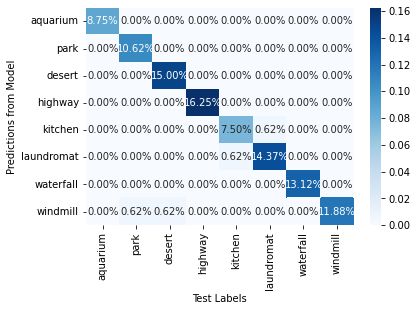

In [21]:
conf_matrix = np.array([[14.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0., 17.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0., 24.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0., 26.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0., 12.,  1.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  1., 23.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0., 21.,  0.],
        [ 0.,  1.,  1.,  0.,  0.,  0.,  0., 19.]])

import seaborn as sns
A = sns.heatmap(conf_matrix/np.sum(conf_matrix), annot=True, xticklabels = [ 'aquarium', 'park', 'desert', 'highway', 'kitchen', 'laundromat', 'waterfall', 'windmill'], yticklabels = [ 'aquarium', 'park', 'desert', 'highway', 'kitchen', 'laundromat', 'waterfall', 'windmill'], fmt='.2%', cmap='Blues')
A.set_xlabel("Test Labels")
A.set_ylabel("Predictions from Model")